## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import math
import copy

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset

from torchsummary import summary

sys.path.insert(0, '.\\Utils')

import models
from train import *
from metrics import * 
#from Gradient_Ascent import data_extraction
from skimage.restoration import denoise_nl_means, estimate_sigma

from PIL import Image
import pdb
import time
import pandas as pd
from scipy.ndimage import gaussian_filter, convolve
from scipy import ndimage


print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Pytorch: 1.4.0+cu92


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [3]:
n_epochs = 100
batch_size = 32*4
lr = 0.01
train_percent = 0.7

## Load ATT Dataset

In [4]:
class ATTdataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    
    def __getitem__(self, idx): 
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = self.file_list[idx]
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
        label = self.people_to_idx[img_path.split('\\')[-2]]
        if self.transform is not None: 
            image = self.transform(image)
        return image, label

In [5]:
data_dir = ".\\attfaces"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
idx_to_people = {}
sample_paths = []
k = 0 
for i in img_paths: 
    name = i.split('\\')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        idx_to_people[k] = name
        k += 1
        sample_paths.append(i)

img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)
lfw_train_size = int(train_percent * lfw_size)
lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([    
    torchvision.transforms.ToTensor(),
])

trainset = ATTdataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = ATTdataset(lfw_test_list, people_to_idx, transform=test_transform)
sampleset = ATTdataset(sample_paths, people_to_idx, transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
sampleloader = torch.utils.data.DataLoader(sampleset, batch_size=40, shuffle=False, num_workers=0)

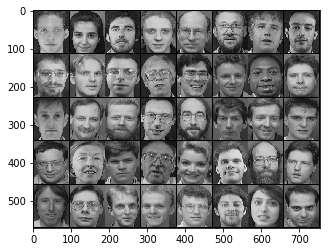

In [6]:
# helper function to unnormalize and plot image 
def imshow(img, name='tmp'):
    img = np.array(img)
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    plt.imsave('.\\'+name, img)
    
# display sample from dataset 
imgs,labels = iter(sampleloader).next()
imshow(torchvision.utils.make_grid(imgs),'.\\results\\origin') 

## Model Architecture

In [7]:
class mlp(nn.Module): 
    def __init__(self, n_in=112*92, n_out=40, n_hidden=1000):
        super(mlp, self).__init__()
        self.hidden1 = nn.Linear(n_in, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_out)
        

    def forward(self, x):
        x = x.view(x.size(0), -1)
#         print(x.shape)
        x = self.hidden1(x)
        x = self.hidden2(x)
        return x

## Training 

In [8]:
net2 = mlp().to(device)
net2.apply(models.weights_init)
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
ww0 = copy.deepcopy(net2.hidden1.weight.data)
bb0 = copy.deepcopy(net2.hidden1.bias.data)
train_accs, test_accs = train(net2, trainloader, testloader, optimizer2, criterion, n_epochs, verbose=False)

[0/100]
Train Accuracy = 1.79 %; Test Accuracy = 3.33 %
[1/100]
Train Accuracy = 5.36 %; Test Accuracy = 4.17 %
[2/100]
Train Accuracy = 10.00 %; Test Accuracy = 5.00 %
[3/100]
Train Accuracy = 7.50 %; Test Accuracy = 5.00 %
[4/100]
Train Accuracy = 13.57 %; Test Accuracy = 8.33 %
[5/100]
Train Accuracy = 23.57 %; Test Accuracy = 14.17 %
[6/100]
Train Accuracy = 22.14 %; Test Accuracy = 15.00 %
[7/100]
Train Accuracy = 28.93 %; Test Accuracy = 20.00 %
[8/100]
Train Accuracy = 35.71 %; Test Accuracy = 16.67 %
[9/100]
Train Accuracy = 45.36 %; Test Accuracy = 22.50 %
[10/100]
Train Accuracy = 46.79 %; Test Accuracy = 23.33 %
[11/100]
Train Accuracy = 52.50 %; Test Accuracy = 30.83 %
[12/100]
Train Accuracy = 59.29 %; Test Accuracy = 45.83 %
[13/100]
Train Accuracy = 73.93 %; Test Accuracy = 59.17 %
[14/100]
Train Accuracy = 72.86 %; Test Accuracy = 50.00 %
[15/100]
Train Accuracy = 72.86 %; Test Accuracy = 51.67 %
[16/100]
Train Accuracy = 80.71 %; Test Accuracy = 62.50 %
[17/100]
Train 

In [9]:
summary(net2,(1,112,92))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]      10,305,000
            Linear-2                   [-1, 40]          40,040
Total params: 10,345,040
Trainable params: 10,345,040
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.01
Params size (MB): 39.46
Estimated Total Size (MB): 39.51
----------------------------------------------------------------


In [10]:
pred = ''
def invert(model, img, lr, c, best_loss, best_x, i):
    if not img.requires_grad:
        img.requires_grad = True
    
    optimizer2.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]).to(device))
    loss.backward()

    img = torch.clamp(img - lr * img.grad, 0, 255)
    
    if loss.cpu().detach().numpy() < best_loss and i > 10: # and i > 10
        best_loss = loss.cpu().detach().numpy()
        best_x = img
    
    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    np_a = np.array([np.clip(x + np.random.normal(1, 1),0,255) for x in img.cpu().detach().numpy()])
    i = convolve(np_a.reshape(112, 92), filt)
    np_a = torch.tensor(np_a).to(device)
    return best_loss, best_x, np_a

In [11]:
torch.save(net2.state_dict(), '.\\results\\state_dict_model.pt')
torch.save(trainloader, '.\\results\\trainloader.pth')
torch.save(testloader, '.\\results\\testloader.pth')
torch.save(sampleloader, '.\\results\\sampleloader.pth')

## DRAM Bit Error Introduction

In [12]:
ww1 = copy.deepcopy(net2.hidden1.weight.data)
bb1 = copy.deepcopy(net2.hidden1.bias.data[:])
ww2 = copy.deepcopy(net2.hidden2.weight.data)
bb2 = copy.deepcopy(net2.hidden2.bias.data[:])

### Float-binary conversion in CPU

In [13]:
# # Determine the fixed point exponent
# nbits = 32 # with one-bit sign
# arr = copy.deepcopy(ww[39,:].reshape(1,1,112,92)).squeeze().cpu().detach().numpy().reshape(-1)
# weight_max = np.absolute(arr).max()
# fixed_exp = np.ceil(np.log2(weight_max/(2**(nbits-1)-1)))

# def float2bin_cpu(num, fixed_exp):
#     if num >= 0:
#         s = '0'
#         tmp = bin(int(num / (2**fixed_exp)))[2:]
#     else:
#         s = '1'
#         tmp = bin(int(num / (2**fixed_exp)))[3:]
#     s += '0'*(nbits-1-len(tmp)) + tmp
#     return s

# def bin2float_cpu(s, fixed_exp):
#     if s[0] == '0':
#         num = 1.0
#     else:
#         num = -1.0
#     num *= int(s[1:],2) * 2**fixed_exp
#     return num

# # evaluation
# for i in range(len(arr)):
#     test = arr[i]
#     rec = bin2float_cpu(float2bin_cpu(test, fixed_exp),fixed_exp)
#     if np.absolute(test-rec) <= 2**fixed_exp:
#         continue
#     else:
#         print(i, test, rec)

### Float-binary conversion in GPU

In [14]:
def float2bin_gpu(f, fixed_exp, nbits=8):
    s = torch.sign(f)
    f = f * s
    s = (s * (-1) + 1.) * 0.5
    s= s.unsqueeze(-1)
    f = f/(2**fixed_exp)
    m = integer2bit(f - f % 1,num_bits = nbits-1)
    dtype = f.type()
    out = torch.cat([s, m], dim=-1).type(dtype)
    return out

def integer2bit(integer, num_bits=7):
    dtype = integer.type()
    exponent_bits = -torch.arange(-(num_bits - 1), 1).type(dtype)
    exponent_bits = exponent_bits.repeat(integer.shape + (1,))
    out = integer.unsqueeze(-1) / 2 ** exponent_bits
    return (out - (out % 1)) % 2

def bin2float_gpu(b, fixed_exp, nbits=8):
    dtype = torch.float32
    s = torch.index_select(b, -1, torch.arange(0, 1).to(device))
    m = torch.index_select(b, -1, torch.arange(1,nbits).to(device))
    out = ((-1) ** s).squeeze(-1).type(dtype)
    exponents = -torch.arange(-(nbits - 2.), 1.).to(device)
    exponents = exponents.repeat(b.shape[:-1] + (1,))
    e_decimal = torch.sum(m * 2 ** (exponents), dim=-1)
    out *= e_decimal * 2 ** fixed_exp
    return out

def bin_add_bit_error(b, bit_error_percent = 0):
    cond = torch.rand(b.shape).to(device) > bit_error_percent
    a = 1 - b
    out = cond * b + torch.logical_not(cond) * a
    return out

# evauluation: make sure the conversion functions work correctly
nbits = 12
f = ww1
weight_max = torch.max(f)
fixed_exp = torch.ceil(torch.log2(weight_max/(2**(nbits-1)-1))) + 1
rec = bin2float_gpu(float2bin_gpu(f, fixed_exp, nbits),fixed_exp, nbits)
if not torch.all((rec - f) <= 1 * 2**fixed_exp):
    print(i, 'binary float conversion failed')
if not torch.all(rec - f >= -1 * 2**fixed_exp):
    print(i, 'binary float conversion failed')

### Get PCC similarity without MIDAS

In [15]:
pcc = 0
mia_n = 2
for c in range(mia_n):
    best_x,best_loss='',float('inf')
    img = torch.zeros_like(testloader.dataset[0][0].unsqueeze(0)).to(device)
    for i in range(30):
        best_loss,best_x,img = invert(net2, img, 1e-2, c, best_loss, best_x, i)
        
    pcc1 = 0
    
    data1 = best_x.reshape(1,1,112,92)/100.0
    vdata1 = data1 - torch.mean(data1)
    
    p = idx_to_people[c]
    for i in os.listdir(os.path.join(data_dir,p)):
        image = np.empty((112, 92, 1), dtype=np.uint8)
        img_path = os.path.join(data_dir,p,i)
        im = io.imread(img_path)
        im = im.reshape(112,92)
        image[:,:,0]= im
        image = train_transform(image).to(device)
        
        data = image.reshape(1,1,112,92) / 100.0
        vdata = data - data.mean()
        pcc1 += torch.sum(vdata*vdata1)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vdata1**2))
        
    pcc1 = pcc1/len(os.listdir(os.path.join(data_dir,p)))
    pcc += pcc1
    
pccbase = pcc/mia_n
np.savetxt('.\\results\\pccbase.csv',[pccbase], delimiter=',')

### Get PCC similarity with MIDAS

In [16]:
# set bit error list
bit_error_percent_list = np.logspace(-3,-12,2,base=2)
bit_error_n = len(bit_error_percent_list)
print(bit_error_percent_list, bit_error_n)

[0.125      0.00024414] 2


In [17]:
test_n = 2
biterror2acc = pd.DataFrame(columns=['test','biterror1','biterror2','acc'])
biterror2pcc = pd.DataFrame(columns=['test','biterror1','biterror2','mia_individual', 'pcc'])
for ntest in range(test_n):
    print("Test no. ", ntest)
    for num1, biterror1 in enumerate(bit_error_percent_list):
        for num2, biterror2 in enumerate(bit_error_percent_list):
            start_time = time.time() 
            
            # introducing errors
            for i in range(ww1.size()[0]):
                f = ww1[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror1), fixed_exp, nbits)
                net2.hidden1.weight.data[i] = f_modify

            for i in range(bb1.size()[0]):
                f = bb1[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror1), fixed_exp, nbits)
                net2.hidden1.bias.data[i] = f_modify

            for i in range(ww2.size()[0]):
                f = ww2[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror2), fixed_exp, nbits)
                net2.hidden2.weight.data[i] = f_modify

            for i in range(bb2.size()[0]):
                f = bb2[i]
                f_modify = bin2float_gpu(bin_add_bit_error(float2bin_gpu(f, fixed_exp, nbits), biterror2), fixed_exp, nbits)
                net2.hidden2.bias.data[i] = f_modify
                
            # get accuracy for modified network
            tmpacc = eval_target_net(net2, testloader)
            biterror2acc = biterror2acc.append({'test': ntest, 'biterror1': biterror1, 'biterror2': biterror2, 'acc': tmpacc}, ignore_index=True)

            # get pcc similarity for modified network
            for c in range(mia_n):
                best_x,best_loss='',float('inf')
                img = torch.zeros_like(testloader.dataset[0][0].unsqueeze(0)).to(device)
                for i in range(30):
                    best_loss,best_x,img = invert(net2, img, 1e-2, c, best_loss, best_x, i)
                    
                pcc1 = 0

                data1 = best_x.reshape(1,1,112,92)/100.0
                vdata1 = data1 - torch.mean(data1)

                p = idx_to_people[c]
                for i in os.listdir(os.path.join(data_dir,p)):
                    image = np.empty((112, 92, 1), dtype=np.uint8)
                    img_path = os.path.join(data_dir,p,i)
                    im = io.imread(img_path)
                    im = im.reshape(112,92)
                    image[:,:,0]= im
                    image = train_transform(image).to(device)

                    data = image.reshape(1,1,112,92) / 100.0
                    vdata = data - data.mean()
                    pcc1 += torch.sum(vdata*vdata1)/torch.sqrt(torch.sum(vdata**2))/torch.sqrt(torch.sum(vdata1**2))

                pcc1 = pcc1/len(os.listdir(os.path.join(data_dir,p)))
                biterror2pcc = biterror2pcc.append({'test': ntest, 'biterror1': biterror1, 'biterror2': biterror2, 'mia_individual': c, 'pcc': pcc}, ignore_index=True)
                
            end_time = time.time()
            # print("time:", end_time-start_time)

Test no.  0
Test no.  1


In [18]:
biterror2acc.to_csv('.\\results\\biterror2acc.csv', index=False)
biterror2pcc.to_csv('.\\results\\biterror2pcc.csv', index=False)

In [19]:
# tmpbiterror2pcc = pd.read_csv('.\\results\\biterror2acc.csv')
# tmpbiterror2acc = pd.read_csv('.\\results\\biterror2acc.csv')
# tmppccbase = np.loadtxt('.\\results\\pccbase.csv', delimiter=',')